# Obtain intermediate embeddings 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

device = torch.device("cuda")

In [10]:
from evo.dataset import FastaDataset
# dataset = FastaDataset("/homefs/home/lux70/storage/data/rocklin/rocklin_stable.fasta")
dataset = FastaDataset("/homefs/home/lux70/storage/data/cath/cath-dataset-nonredundant-S40.atom.fa")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64)

from plaid.esmfold import esmfold_v1
esmfold = esmfold_v1()
esmfold = esmfold.to(device)

100%|██████████| 5.57M/5.57M [00:00<00:00, 139MB/s]
100%|██████████| 5.57M/5.57M [00:00<00:00, 160MB/s]


Creating ESMFold...
ESMFold model loaded in 0.66 minutes.


In [11]:
from plaid.transforms import get_random_sequence_crop_batch

headers, sequences = next(iter(dataloader))
sequences = get_random_sequence_crop_batch(sequences, max_len=512)
print(sequences[:3])

['AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSGAEKAVQVKVKALPDAQFEVVHSLAKWKRQTLGQHDFSAGEGLYTHMKALRPDEDRLSPLHSVYVDQWDWERVMGDGERQFSTLKSTVEAIWAGIKATEAAVSEEFGLAPFLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLVGIGGKLSDGHRHDVRAPDYDDWSTPSELGHAGLNGDILVWNPVLEDAFELSSMGIRVDADTLKHQLALTGDEDRLELEWHQALLRGEMPQTIGGGIGQSRLTMLLLQLPHIGQVQAGVWPAAVRESVPSLL', 'VFGRCELAAAMRHGLDNYRGYSLGNWVCAAFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKIVSDGNGMNAWVAWRNRCGTDVQAWIRGCRL', 'RTDCYGNVNRIDTTGASCKTAKPEGLSYCGVSASKKIAERDLQAMDRYKTIIKKVGEKLCVEPAVIAGIISRESHAGKVLKNGWGDRGNGFGLMQVDKRSHKPQGTWNGEVHITQGTTILINFIKTIQKKFPSWTKDQQLKGGISAYNAGAGNVRSYARMDIGTTHDDYANDVVARAQYYKQHGY']


In [12]:
# tmp: try first 3 only for reproduction
sequences = ['AYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQDNLSGAEKAVQVKVKALPDAQFEVVHSLAKWKRQTLGQHDFSAGEGLYTHMKALRPDEDRLSPLHSVYVDQWDWERVMGDGERQFSTLKSTVEAIWAGIKATEAAVSEEFGLAPFLPDQIHFVHSQELLSRYPDLDAKGRERAIAKDLGAVFLVGIGGKLSDGHRHDVRAPDYDDWSTPSELGHAGLNGDILVWNPVLEDAFELSSMGIRVDADTLKHQLALTGDEDRLELEWHQALLRGEMPQTIGGGIGQSRLTMLLLQLPHIGQVQAGVWPAAVRESVPSLL']
# , 'VFGRCELAAAMRHGLDNYRGYSLGNWVCAAFESNFNTQATNRNTDGSTDYGILQINSRWWCNDGRTPGSRNLCNIPCSALLSSDITASVNCAKIVSDGNGMNAWVAWRNRCGTDVQAWIRGCRL', 'RTDCYGNVNRIDTTGASCKTAKPEGLSYCGVSASKKIAERDLQAMDRYKTIIKKVGEKLCVEPAVIAGIISRESHAGKVLKNGWGDRGNGFGLMQVDKRSHKPQGTWNGEVHITQGTTILINFIKTIQKKFPSWTKDQQLKGGISAYNAGAGNVRSYARMDIGTTHDDYANDVVARAQYYKQHGY']

with torch.no_grad():
    intermediates = esmfold.infer_embedding(sequences, return_intermediates=True)

In [13]:
lm_res = intermediates.pop('lm_res')
mask = intermediates.pop("mask")
pos = intermediates.pop("pos")
print(intermediates.keys())
print(intermediates['s'].shape)

dict_keys(['esm_s', 's_post_softmax', 's_post_mlp', 's', 'aa_embed', 'z'])
torch.Size([1, 327, 1024])


In [14]:
for k, v in intermediates.items():
    print(k, "=" * 10)
    print(v.shape)
    print(v.max().item(), v.min().item(), v.mean().item(), v.std().item())
    print()

esm_s ==========
torch.Size([1, 327, 37, 2560])
1274.0 -170.125 0.03131103515625 15.40625

s_post_softmax ==========
torch.Size([1, 327, 2560])
49.05341720581055 -4.0512847900390625 -0.005650366190820932 0.9514164328575134

s_post_mlp ==========
torch.Size([1, 327, 1024])
2630.560546875 -802.800537109375 1.2890806198120117 73.19300079345703

s ==========
torch.Size([1, 327, 1024])
2630.560546875 -802.800537109375 1.2890806198120117 73.19300079345703

aa_embed ==========
torch.Size([1, 327, 1024])
7.411594390869141 -6.440321922302246 0.014687142334878445 1.7496414184570312

z ==========
torch.Size([1, 327, 327, 128])
0.0 0.0 0.0 0.0



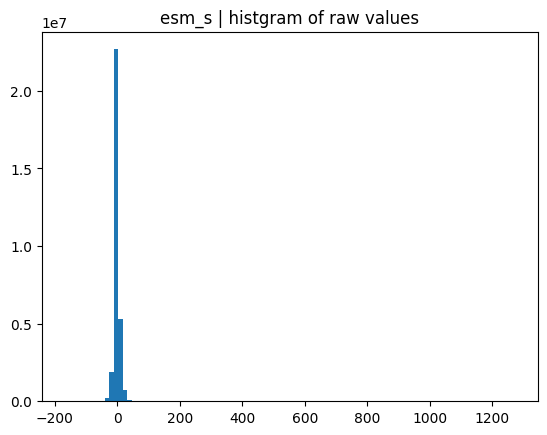

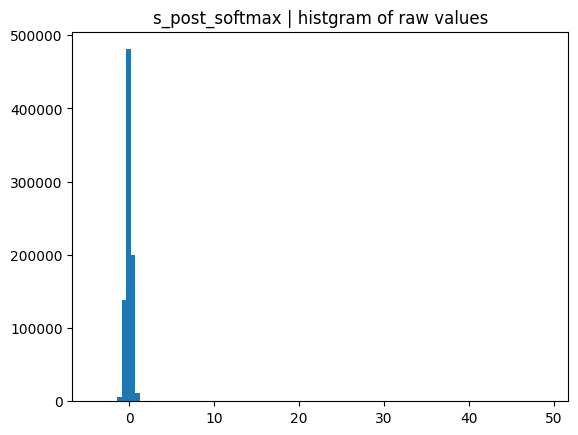

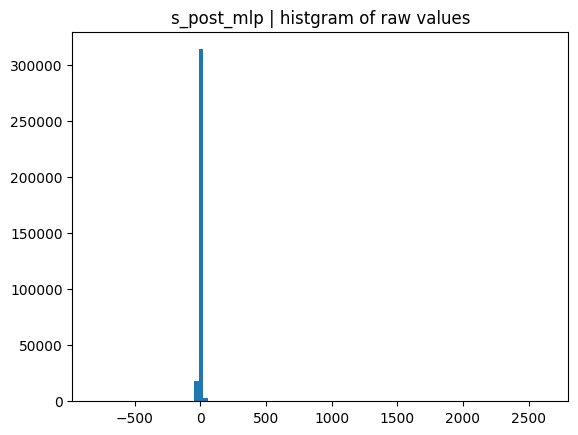

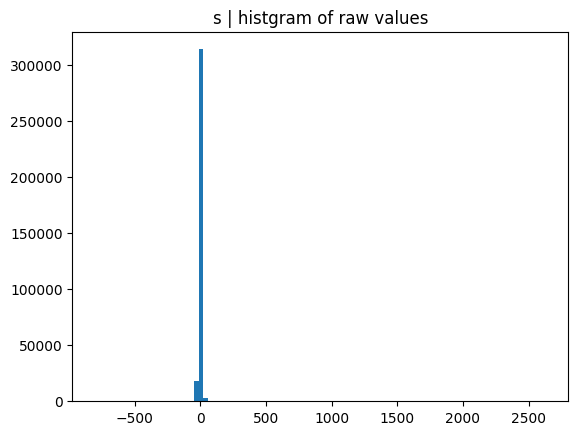

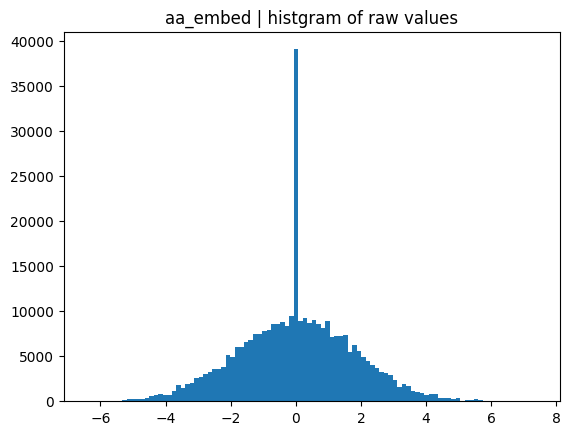

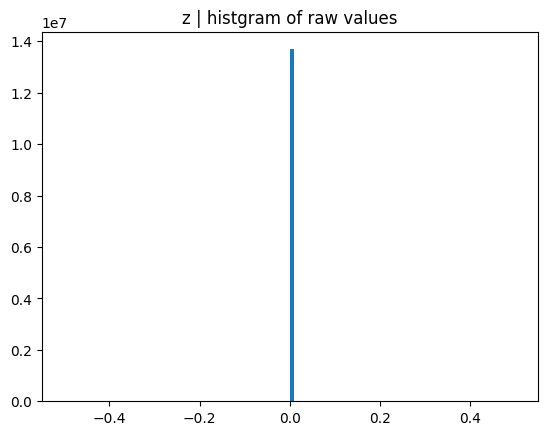

In [15]:
import matplotlib.pyplot as plt

hists = {}

for k, v in intermediates.items():
    plt.clf()
    plt.hist(v.detach().cpu().numpy().reshape(-1,), bins=100)
    plt.title(f"{k} | histgram of raw values")
    plt.show()


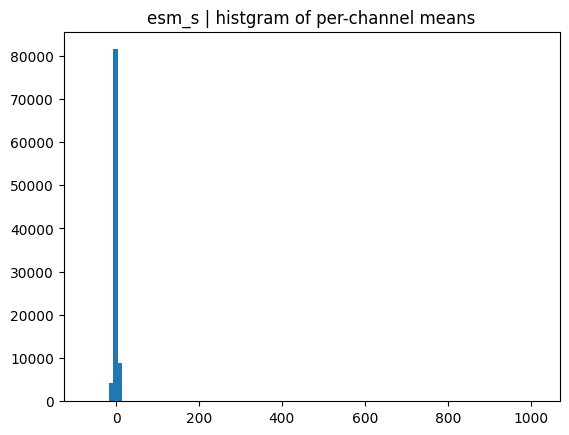

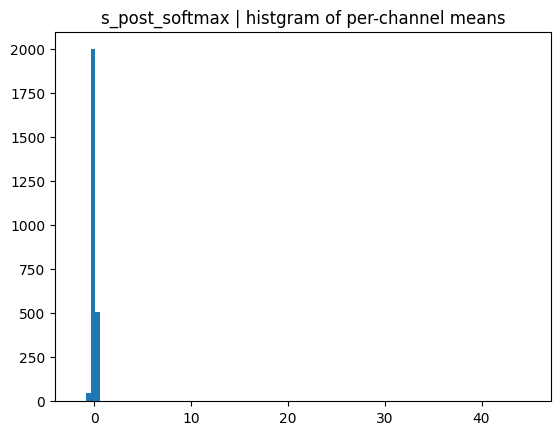

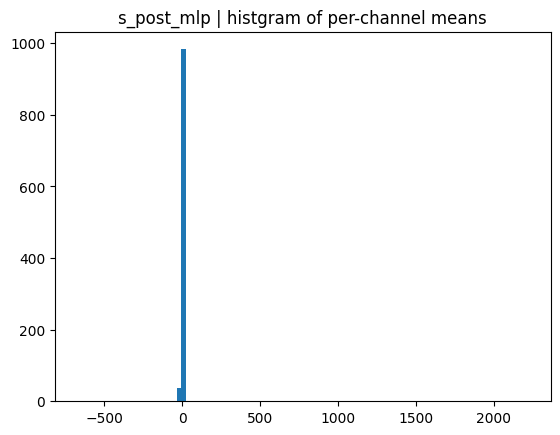

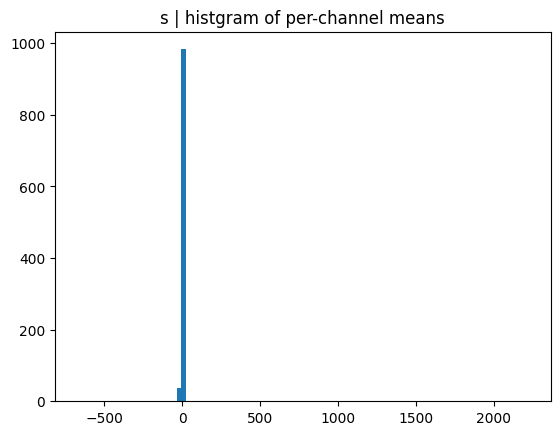

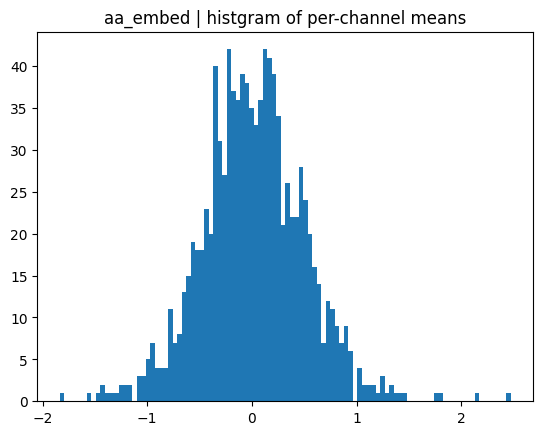

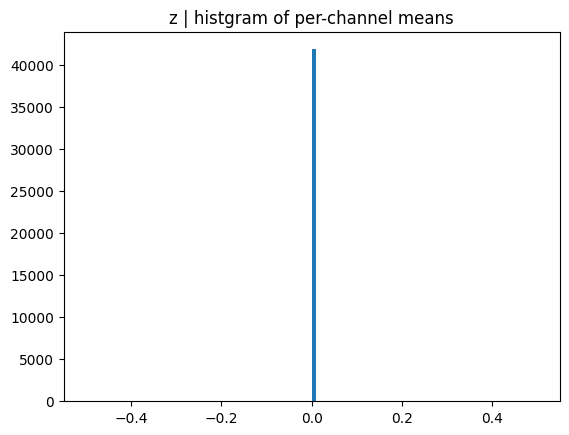

In [9]:
import matplotlib.pyplot as plt

hists = {}

for k, v in intermediates.items():
    plt.clf()
    plt.hist(v.mean(dim=(0,1)).detach().cpu().numpy().reshape(-1,), bins=100)
    plt.title(f"{k} | histgram of per-channel means")
    plt.show()


In [10]:
intermediates['s_post_softmax'].shape

torch.Size([64, 438, 2560])

In [11]:
values, indices = intermediates['s_post_softmax'].mean(dim=(0,1)).sort()
print(values)
print(indices)

print(values[-10:])
print(indices[-10:])

tensor([-2.0734, -1.0137, -0.9686,  ...,  1.0116,  1.8290, 52.5188],
       device='cuda:0')
tensor([ 636, 1116,  461,  ...,  696, 2482, 1542], device='cuda:0')
tensor([ 0.4266,  0.5015,  0.5324,  0.5354,  0.5992,  0.6793,  0.8323,  1.0116,
         1.8290, 52.5188], device='cuda:0')
tensor([ 851, 1944, 1053, 2502,  411, 1150,  228,  696, 2482, 1542],
       device='cuda:0')


Text(0.5, 1.0, 's_post_softmax | per channel means, remove 4 outlier values')

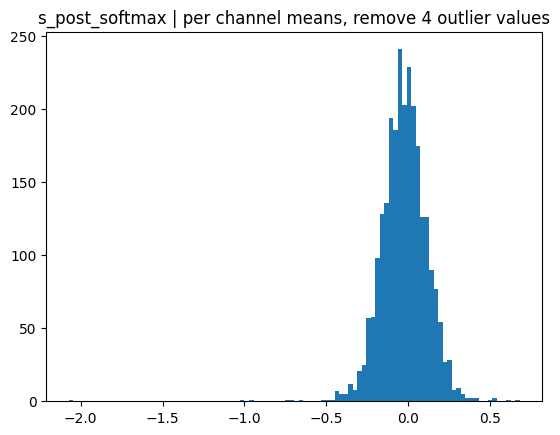

In [12]:
tmp = intermediates['s_post_softmax'].mean(dim=(0,1)).clone()
tmp[indices[-4:]] = torch.zeros((4,), device=tmp.device)
tmp[1542] = 0 # torch.zeros((tmp.shape[-1],), device=tmp.device)
_ = plt.hist(tmp.cpu().numpy().reshape(-1), bins=100)
plt.title("s_post_softmax | per channel means, remove 4 outlier values")

## Downprojecting the channel dimension
### Unnormalized: `s_post_softmax`

In [25]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
s_post_softmax = intermediates['s_post_softmax'].cpu().numpy()

(64, 438)
(28032,)


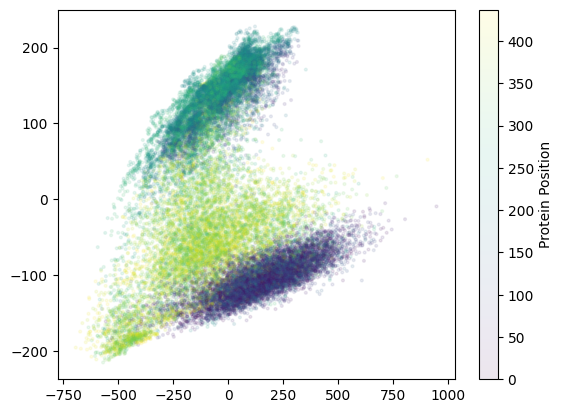

In [35]:
carr = np.broadcast_to(np.arange(s_post_softmax.shape[1])[None, :], s_post_softmax.shape[:2])
print(carr.shape)
carr = carr.reshape(-1)
print(carr.shape)

plt.scatter(out[:, 0], out[:, 1], alpha=0.1, s=4, c=carr)
cbar = plt.colorbar()
cbar.set_label("Protein Position")

In [31]:
carr = np.broadcast_to(np.arange(intermediates['s'].shape[1])[None, :], intermediates['s'].shape[:2])
print(carr.shape)
carr = carr.reshape(-1)
print(carr.shape)


(28032, 1024)


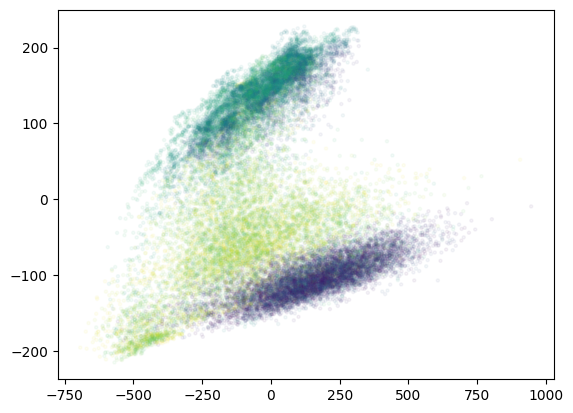

In [39]:
s = intermediates['s'].cpu().numpy()
tmp = s.reshape(-1, s.shape[-1])
print(tmp.shape)
out = pca.fit_transform(tmp)
plt.scatter(out[:,0], out[:,1], s=5, c=carr, alpha=0.05)